# Search Engine Evaluation and Near Duplicate Detection

To complete our tasks we will use the PyTerrier library.

### Imports

In [ ]:
!pip install python-terrier # PyTerrier is a recent library so it is not ensured it will work properly on your local pc, use Colab instead

import pyterrier as pt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import random
import itertools as it
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

if not pt.started(): pt.init() # PyTerrier has to be initialized with this command line


### Downloading the dataset to index

In [ ]:
dataset = pt.get_dataset('irds:nfcorpus/dev') # download dataset
dataset.get_topics()

folder_pos = './indices/' # the indexes will be stored in a specific folder
!rm -r $folder_pos

### Indexing function

To start we only index on the title.

In [ ]:
def create_index(preprocessing_configuration, field, folder_pos):

  !rm -rf $folder_pos

    indexer = pt.IterDictIndexer(folder_pos, meta_reverse = [], blocks = True)
    indexer.setProperty("termpipelines", preprocessing_configuration)
    indexref = indexer.index(dataset.get_corpus_iter(), fields = [field], meta=['docno', 'title', 'abstract'])  

  return indexref

# different preprocessing configurations in order to compare them later 

index1 = create_index(preprocessing_configuration = "NoOp", field = "title", folder_pos = folder_pos+'index1')
index2 = create_index(preprocessing_configuration = "Stopwords,RemoveDiacritics,TRv2PorterStemmer", field = "title", folder_pos = folder_pos+'index2')
index3 = create_index(preprocessing_configuration = "Stopwords,RemoveDiacritics,PorterStemmer", field = "title", folder_pos = folder_pos+'index3')
index4 = create_index(preprocessing_configuration = "Stopwords,RemoveDiacritics,EnglishSnowballStemmer", field = "title", folder_pos = folder_pos+'index4')
index5 = create_index(preprocessing_configuration = "Stopwords,RemoveDiacritics,WeakPorterStemmer", field = "title", folder_pos = folder_pos+'index5')

index_factory = pt.IndexFactory.of(index1)
print(index_factory.getCollectionStatistics().toString()[:47])


Number of documents: 5371
Number of terms: 6638


## SEARCH ENGINE EVALUATION

### Weighting models and evalutation metrics

In [ ]:
#YOUR CODE STARTS HERE#

wmodels = ["TF_IDF", "LemurTF_IDF", "BM25F", "PL2F", "CoordinateMatch"]

NoOp_Models_Dict = {}
TRv2_Models_Dict = {}
Porter_Models_Dict = {}
ESS_Models_Dict = {}
WPorter_Models_Dict = {}

# for each model we'll try each preprocessing configuration

for md in wmodels:
  NoOp_Models_Dict[md] = pt.BatchRetrieve(index1, wmodel=md)
  TRv2_Models_Dict[md] = pt.BatchRetrieve(index2, wmodel=md)
  Porter_Models_Dict[md] = pt.BatchRetrieve(index3, wmodel=md)
  ESS_Models_Dict[md] = pt.BatchRetrieve(index4, wmodel=md)
  WPorter_Models_Dict[md] = pt.BatchRetrieve(index5, wmodel=md)

# compare the models by means of different evaluation metrics

eval_metrics = ['P_5', 'ndcg_cut_10', 'recip_rank', 'map', 'recall_5', 'recall_10', 'mrt', 'num_rel_ret']


### Running experiments

Experiments allow us to compare different configution, models and metrics by just passing the arguments.

In [ ]:
topics = dataset.get_topics("title")
qrels = dataset.get_qrels()
names = ['NoOp_TF_IDF', 'NoOp_LemurTF_IDF', 'NoOp_BM25F', 'NoOp_PL2F', 'NoOp_CM', 'TRv2_TF_IDF', 'TRv2_LemurTF_IDF', 'TRv2_BM25F', 'TRv2_PL2F', 'TRv2_CM', 'Porter_TF_IDF', 'Porter_LemurTF_IDF', 'Porter_BM25F', 'Porter_PL2F', 'Porter_CM', 'ESS_TF_IDF', 'ESS_LemurTF_IDF', 'ESS_BM25F', 'ESS_PL2F', 'ESS_CM', 'WPorter_TF_IDF', 'WPorter_LemurTF_IDF', 'WPorter_BM25F', 'WPorter_PL2F', 'WPorter_CM']
models_dicts = [NoOp_Models_Dict, TRv2_Models_Dict, Porter_Models_Dict, ESS_Models_Dict, WPorter_Models_Dict]
models = []

for dic in models_dicts:
  for md in wmodels:
    models.append(dic[md])
  
exp = pt.Experiment(
    models,
    topics,
    qrels,
    eval_metrics = eval_metrics,
    names = names,
    highlight = "bold"
)

exp_df = exp.data

# adding a column preprocessing that specifies the preprocessing pipeline used
exp_df['preprocessing'] = ['NoOp','NoOp','NoOp','NoOp','NoOp',"Stopwords,RemoveDiacritics,TRv2PorterStemmer", "Stopwords,RemoveDiacritics,TRv2PorterStemmer", "Stopwords,RemoveDiacritics,TRv2PorterStemmer", "Stopwords,RemoveDiacritics,TRv2PorterStemmer", "Stopwords,RemoveDiacritics,TRv2PorterStemmer",
                           "Stopwords,RemoveDiacritics,PorterStemmer", "Stopwords,RemoveDiacritics,PorterStemmer", "Stopwords,RemoveDiacritics,PorterStemmer", "Stopwords,RemoveDiacritics,PorterStemmer", "Stopwords,RemoveDiacritics,PorterStemmer",
                           "Stopwords,RemoveDiacritics,EnglishSnowballStemmer", "Stopwords,RemoveDiacritics,EnglishSnowballStemmer", "Stopwords,RemoveDiacritics,EnglishSnowballStemmer", "Stopwords,RemoveDiacritics,EnglishSnowballStemmer", "Stopwords,RemoveDiacritics,EnglishSnowballStemmer",
                           "Stopwords,RemoveDiacritics,WeakPorterStemmer", "Stopwords,RemoveDiacritics,WeakPorterStemmer", "Stopwords,RemoveDiacritics,WeakPorterStemmer", "Stopwords,RemoveDiacritics,WeakPorterStemmer", "Stopwords,RemoveDiacritics,WeakPorterStemmer"]



,name,P_5,ndcg_cut_10,recip_rank,map,recall_5,recall_10,num_rel_ret,mrt,preprocessing
0,NoOp_TF_IDF,0.154462,0.154429,0.336203,0.043947,0.040392,0.058245,1934.0,43.906566,NoOp
1,NoOp_LemurTF_IDF,0.162462,0.160171,0.338339,0.046941,0.045038,0.062933,1938.0,40.338141,NoOp
2,NoOp_BM25F,0.156308,0.151034,0.328243,0.042846,0.040441,0.058891,1921.0,49.277730,NoOp
3,NoOp_PL2F,0.155077,0.154751,0.336328,0.043999,0.040106,0.058509,1934.0,48.352679,NoOp
4,NoOp_CM,0.113231,0.107860,0.240882,0.031298,0.028491,0.046760,1603.0,42.462347,NoOp
5,TRv2_TF_IDF,0.190154,0.184510,0.387960,0.058761,0.054247,0.070504,1941.0,22.146085,"Stopwords,RemoveDiacritics,TRv2PorterStemmer"
6,TRv2_LemurTF_IDF,0.192615,0.188725,0.390844,0.061011,0.056008,0.072691,1944.0,20.451956,"Stopwords,RemoveDiacritics,TRv2PorterStemmer"
7,TRv2_BM25F,0.188923,0.182909,0.394226,0.058327,0.050109,0.067033,1941.0,22.405152,"Stopwords,RemoveDiacritics,TRv2PorterStemmer"
8,TRv2_PL2F,0.190769,0.183825,0.388012,0.058793,0.054209,0.070256,1941.0,22.002487,"Stopwords,RemoveDiacritics,TRv2PorterStemmer"
9,TRv2_CM,0.142769,0.137364,0.298655,0.047460,0.039453,0.056216,1931.0,21.321848,"Stopwords,RemoveDiacritics,TRv2PorterStemmer"


### Top-5 configurations according to the Mean Recirpocal Rank (MRR)

In [ ]:
# sort dataframe for MRR and find top 5 configuration names
sorted_exp_by_MRR = exp_df.sort_values(by = 'recip_rank', ascending=False)
names_top5 = list(sorted_exp_by_MRR['name'][:5])

top_5_configuration = [Porter_Models_Dict['BM25F'], Porter_Models_Dict['PL2F'], ESS_Models_Dict['BM25F'], ESS_Models_Dict['LemurTF_IDF'], TRv2_Models_Dict['BM25F']]


* P@k plot
    * the x axis represents the considered values for k: you must consider k 𝜖 {1, 3, 5, 10}
    * the y axis represents the average P@k over all provided queries
    * each curve represents one of the 5 search engine configurations

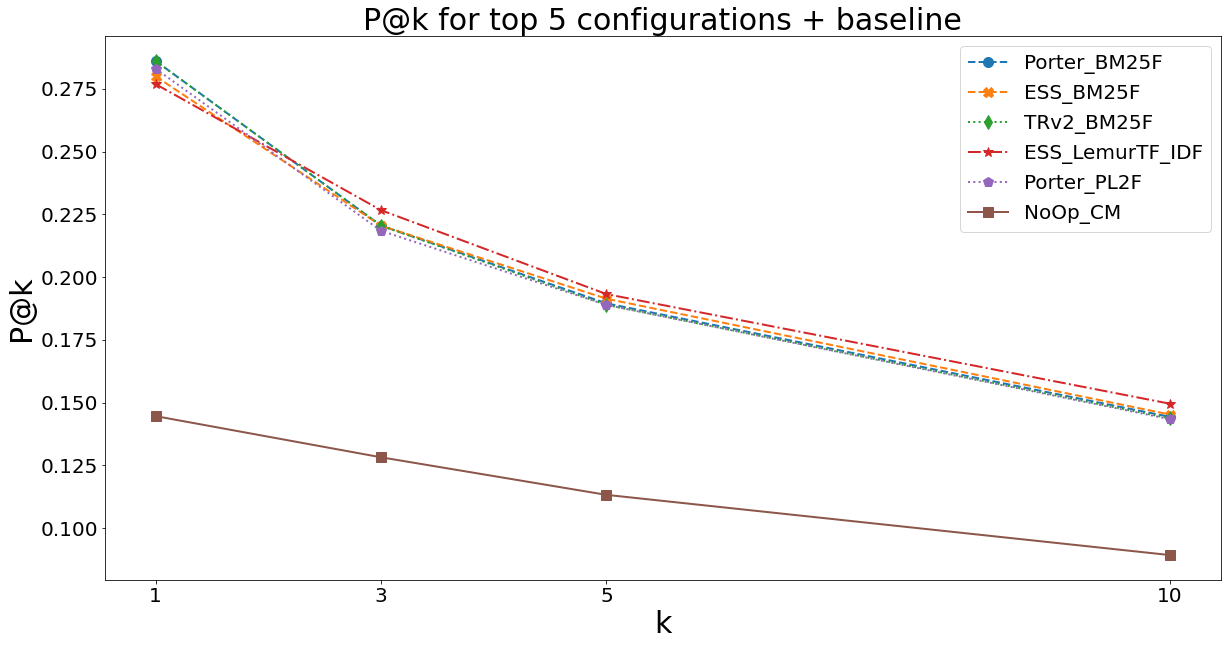

In [ ]:
precision_metrics = ['P_1', 'P_3', 'P_5', 'P_10']

out = pt.Experiment(
     
        [*top_5_configuration, NoOp_Models_Dict['CoordinateMatch']], # adding also the worst possible model according to MRR as baseline {preprocessing: 'NoOp', wmodel: 'CoordinateMatch'}
        topics,
        qrels,
        eval_metrics = precision_metrics,
        names = [*names_top5, 'NoOp_CM'],
        highlight="bold")

k = [1, 3, 5, 10]

lines = ['--o', '--X', ':d', '-.*', ':p', '-s']

plt.figure(figsize = (20, 10))

for row in range(0, len(out.data)):

  plt.plot(k, list(out.data.iloc[row, 1:]), lines[row], linewidth = 2, markersize = 10, label = [*names_top5, 'NoOp_CM'][row])
  plt.title('P@k for top 5 configurations + baseline', size = 30)
  plt.xlabel('k', fontsize = 30)
  plt.xticks(k, k, fontsize=20)
  plt.ylabel('P@k', fontsize = 30)
  plt.yticks(fontsize=20)
  plt.legend(prop = {'size': 20})

* nDCG@k plot
    * the x axis represents the considered values for k: you must consider k 𝜖 {1, 3, 5, 10}
    * the y axis represents the average nDCG@k over all provided queries
    * each curve represents one of the 5 search engine configurations

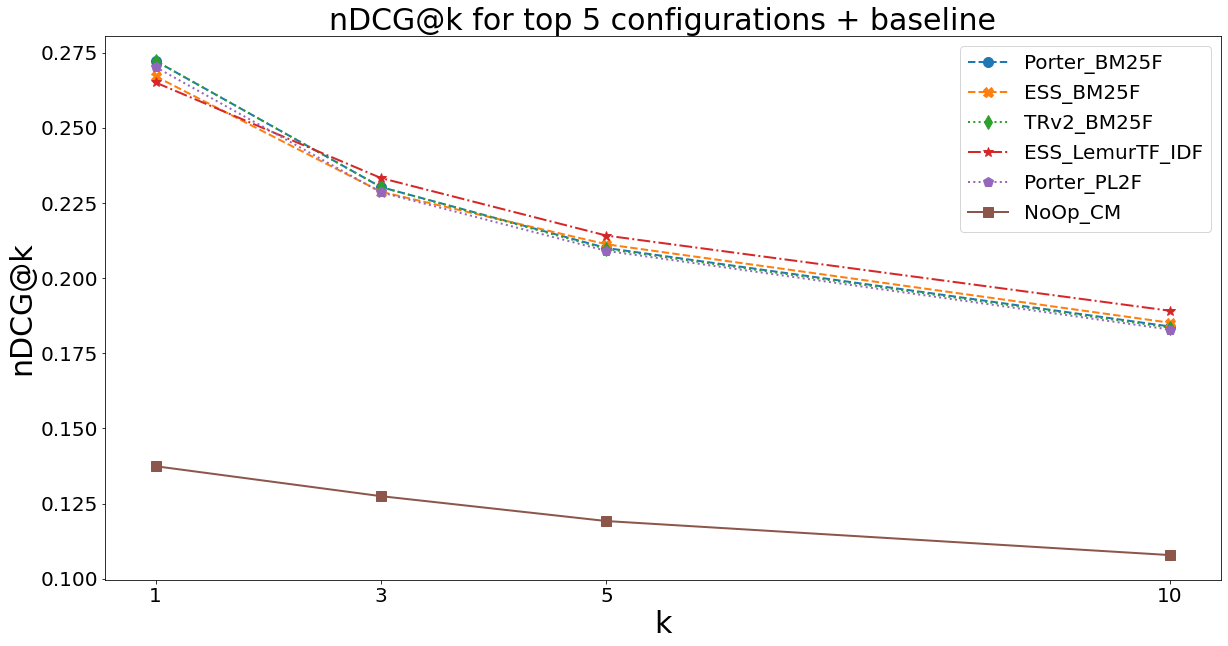

In [ ]:
ndcg_metrics = ['ndcg_cut_1', 'ndcg_cut_3', 'ndcg_cut_5', 'ndcg_cut_10']

out = pt.Experiment(

        [*top_5_configuration, NoOp_Models_Dict['CoordinateMatch']], # adding also the worst possible model according to MRR as baseline {preprocessing: 'NoOp', wmodel: 'CoordinateMatch'}
        topics,
        qrels,
        eval_metrics = ndcg_metrics,
        names = [*names_top5, 'NoOp_CM'],
        highlight="bold")

k = [1, 3, 5, 10]

plt.figure(figsize = (20, 10))

for row in range(0, len(out.data)):

  plt.plot(k, list(out.data.iloc[row, 1:]), lines[row], linewidth = 2, markersize = 10, label = [*names_top5, 'NoOp_CM'][row])
  plt.title('nDCG@k for top 5 configurations + baseline', size = 30)
  plt.xlabel('k', fontsize = 30)
  plt.xticks(k, k, fontsize=20)
  plt.ylabel('nDCG@k', fontsize = 30)
  plt.yticks(fontsize=20)
  plt.legend(prop = {'size': 20})

## NEAR DUPLICATE DETECTION

The constraints considered while carrying out this part were:

  * Considering Near-duplicates all those pair of documents that have a Jaccard similarity greater than or equal to 0.95
  * Each set of shingles, that represents an original document, must be sketched in a Min-Hashing sketch with a length of at most 210
  * The probability to have as a near-duplicate candidate a pair of documents with Jaccard=0.95 must be > 0.97
  * The generation process of near-duplicate pairs you implement must generate the smallest amount of both **False-Negatives** and **False-Positives**
  * The running time of all the LSH process must be less than 10 minutes.

### NDD functions
A range of functions to perform the Near-Duplicates pipeline.

##### Shingling

> The `cleaner` function will remove from a string all the characters that are not in a predefined set of characters of interest. Multiple spaces will be removed automatically. The function will also remove spaces at the start and end of the sentence, and change all the letters to lowercase.

In [ ]:
set__characters_of_interest = set(
    [' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
     'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])
def cleaner(text, set__characters_of_interest):
    new_text = ""
    #
    previous_copied_character = "a"
    for c_character in text:
        #
        c_character = c_character.lower()
        #
        if c_character not in set__characters_of_interest:
            c_character = " "
        #
        if c_character == " " and c_character == previous_copied_character:
            continue
        #
        new_text += c_character
        #
        previous_copied_character = c_character
        #
    #
    new_text = new_text.strip()
    #
    return new_text

> The `get_shingle_id` function will transform a shingle (a tuple of strings) into its shingle id. The `map__shingle__shingle_id` dictionary will handle the mapping.

In [ ]:
def get_shingle_id(shingle):
    global max_shingle_id
    global map__shingle__shingle_id
    #
    shingle_id = map__shingle__shingle_id.get(shingle, -1)
    #
    if shingle_id >= 0:
        return shingle_id
    #
    max_shingle_id += 1
    shingle_id = max_shingle_id
    map__shingle__shingle_id[shingle] = max_shingle_id
    #
    return shingle_id

> The `shingler` function takes as input a string and (optionally) a shingle width. It splits the string into words, then iterates in groups of the given length, transforming each into its own shingle_id, and finally outputs the set of shingles that constitutes the sentence.

In [ ]:
def shingler(text, width=2):
    #
    set__shingle_id = set()
    #
    tokenized_text = text.split(" ")
    #
    max_index_plus_1 = 1 if len(tokenized_text) <= width else len(tokenized_text) - width +1
    for index in range(max_index_plus_1):
        #
        c_shingle = tuple(tokenized_text[index:index + width])
        #
        shingle_id = get_shingle_id(c_shingle)
        #
        # if shingle_id in set__shingle_id:
        #    print(shingle_id, c_shingle)
        #
        res = set__shingle_id.add(shingle_id)
        #
    return set__shingle_id

> This function will load each sentence inside the input file. The rows of the input file must have two attributes: document_id and document_text. For each record, the text will be processed by the `cleaner` function, turned into shingles by the `shingler` function, and the result will be written in the output file.

In [ ]:
def create_sets_of_shingle_ids(input_file_name, output_file_name,
                               input_file_delimiter='\t', input_file_quotechar='"',
                               set__characters_of_interest=[" "], shingle_width=3,
                               doc_id_column_idx=0, field_column_idx=1):
    #
    output_file = open(output_file_name, 'w', encoding="utf-8")
    output_file_csv_writer = csv.writer(output_file, delimiter='\t', quotechar='"', quoting=csv.QUOTE_NONE)
    header = ['set_id', 'set_of_integers']
    output_file_csv_writer.writerow(header)
    #
    input_file = open(input_file_name, 'r', encoding="utf-8")
    input_file_csv_reader = csv.reader(input_file, delimiter=input_file_delimiter, quotechar=input_file_quotechar)
    next(input_file_csv_reader)
    for record in input_file_csv_reader:
        #
        doc_id = int(record[doc_id_column_idx])
        document = record[field_column_idx]
        #
        cleaned_document = cleaner(document, set__characters_of_interest)
        #
        set__shingle_id = shingler(cleaned_document, width=shingle_width)
        #
        output_file_csv_writer.writerow([doc_id, set__shingle_id])
        #
        #
        if doc_id % 1000 == 0:
            print("Last processed doc_id:", doc_id)
        #
    input_file.close()
    output_file.close()
    print("Last processed doc_id:", doc_id)
    print()
    print("max_shingle_id=", max_shingle_id)
    print()
    print()
    return max_shingle_id

##### MinWise Hashing

> This simple function will (smartly) check if a number is prime.

In [ ]:
def is_prime(number):
    #
    if number == 2:
        return True
    if (number % 2) == 0:
        return False
    for j in range(3, int(number ** 0.5 + 1), 2):
        if (number % j) == 0:
            return False
    #
    return True

> The `create_hash_functions` function will take as input the number of hash function desired and the upper bound on the number of distinct elements. It will generate the three values `(a, b, p)` that defines an hash function `number_of_hash_functions` times and return all this information into a dictionary. The optional seed argument will be used to set the random seed, so that the hash function obtained can be controlled.

In [ ]:
def create_hash_functions(number_of_hash_functions, upper_bound_on_number_of_distinct_elements, seed=42):
    random.seed(seed)
    #
    map__hash_function_id__a_b_p = {}
    #
    set_of_all_hash_functions = set()
    while len(set_of_all_hash_functions) < number_of_hash_functions:
        a = random.randint(1, upper_bound_on_number_of_distinct_elements - 1)
        b = random.randint(0, upper_bound_on_number_of_distinct_elements - 1)
        p = random.randint(upper_bound_on_number_of_distinct_elements, 10 * upper_bound_on_number_of_distinct_elements)
        while is_prime(p) == False:
            p = random.randint(upper_bound_on_number_of_distinct_elements,
                               10 * upper_bound_on_number_of_distinct_elements)
        #
        c_hash_function = (a, b, p)
        set_of_all_hash_functions.add(c_hash_function)
    #
    for c_hash_function_id, c_hash_function in enumerate(set_of_all_hash_functions):
        map__hash_function_id__a_b_p[c_hash_function_id] = c_hash_function
    #
    return map__hash_function_id__a_b_p

> The `create_c_set_MinWiseHashing_sketch` function will receive as input a set of shingles, a list of hash functions parameters and the total number of hash functions to use. For each hash function, it applies it to each shingle and keeps the minimum value. It gives as output the MinWiseHashing sketch as a list.

In [ ]:
def create_c_set_MinWiseHashing_sketch(c_set,
                                       map_as_list__index__a_b_p,
                                       total_number_of_hash_functions):
    plus_inf = float("+inf")
    c_set_MinWiseHashing_sketch = [plus_inf] * total_number_of_hash_functions
    #
    for c_element_id in c_set:
        index = -1
        for a, b, p in map_as_list__index__a_b_p:
            index += 1
            #
            c_hash_value = (a * c_element_id + b) % p
            #
            if c_hash_value < c_set_MinWiseHashing_sketch[index]:
                c_set_MinWiseHashing_sketch[index] = c_hash_value
            #
        #   
    #
    return c_set_MinWiseHashing_sketch

> The `create_MinWiseHashing_sketches` function first generates the list of hash functions. Then it iterates through the input file containing the set of shingles for each document, computing the MinWiseHashing sketch for each set of shingles and storing this information into a dictionary. This variable is then saved into an output file.

In [ ]:
def create_MinWiseHashing_sketches(input_file_name, upper_bound_on_number_of_distinct_elements,
                                   number_of_hash_functions_that_is_also_the_sketch_lenght_and_also_the_number_of_simulated_permutations,
                                   output_file_name):
    #
    map__hash_function_id__a_b_p = create_hash_functions(
        number_of_hash_functions_that_is_also_the_sketch_lenght_and_also_the_number_of_simulated_permutations,
        upper_bound_on_number_of_distinct_elements)
    #
    map__set_id__MinWiseHashing_sketch = {}
    #
    total_number_of_hash_functions = len(map__hash_function_id__a_b_p)
    # sorted_list_all_hash_function_id = sorted(map__hash_function_id__a_b_p.keys())
    map_as_list__index__a_b_p = tuple([(a, b, p) for a, b, p in map__hash_function_id__a_b_p.values()])
    #
    input_file = open(input_file_name, 'r', encoding="utf-8")
    input_file_csv_reader = csv.reader(input_file, delimiter='\t', quotechar='"', quoting=csv.QUOTE_NONE)
    header = next(input_file_csv_reader)
    num_record_so_far = 0
    for record in input_file_csv_reader:
      num_record_so_far += 1
      if num_record_so_far % 100 == 0:
          print(num_record_so_far)
      c_set_id = int(record[0])
      c_set = eval(record[1])

      c_set_MinWiseHashing_sketch = create_c_set_MinWiseHashing_sketch(c_set,map_as_list__index__a_b_p,total_number_of_hash_functions)
      
      #print(len(c_set_MinWiseHashing_sketch))
      map__set_id__MinWiseHashing_sketch[c_set_id] = c_set_MinWiseHashing_sketch
    input_file.close()
    #
    output_file = open(output_file_name, 'w', encoding="utf-8")
    output_file_csv_writer = csv.writer(output_file, delimiter='\t', quotechar='"', quoting=csv.QUOTE_NONE)
    header = ['set_id', 'MinWiseHashing_sketch']
    output_file_csv_writer.writerow(header)
    sorted_list_all_set_id = sorted(map__set_id__MinWiseHashing_sketch.keys())
    for c_set_id in sorted_list_all_set_id:
        output_file_csv_writer.writerow([c_set_id, str(map__set_id__MinWiseHashing_sketch[c_set_id])])
    output_file.close()
    #
    return

##### Locality-Sensitive Hashing

> This function will simply load the MinWiseHashing sketches from the given input file.

In [ ]:
def load_map__set_id__MinWiseHashing_sketch_from_file(input_file_name):
    map__set_id__MinWiseHashing_sketch = {}
    #
    input_file = open(input_file_name, 'r', encoding="utf-8")
    input_file_csv_reader = csv.reader(input_file, delimiter='\t', quotechar='"', quoting=csv.QUOTE_NONE)
    header = next(input_file_csv_reader)
    for record in input_file_csv_reader:
        c_set_id = int(record[0])
        c_MinhiseHashing_sketch = tuple(eval(record[1]))
        #
        map__set_id__MinWiseHashing_sketch[c_set_id] = c_MinhiseHashing_sketch
        #
    input_file.close()
    #
    return map__set_id__MinWiseHashing_sketch

> The function computes the sets of unordered couples of document identifiers for which there is at least one band in common between the MinWiseHashing sketches. It takes in input the number or rows and the number of bands and the MinWiseHashing sketches. The number of rows (r) multiplied by the number of bands (b) must be equal to the size of the sketches (n): r*b = n.

In [ ]:
def get_set_of_CANDIDATES_to_be_near_duplicates(r, b, map__set_id__MinWiseHashing_sketch):
    #
    set_of_CANDIDATES_to_be_near_duplicates = set()
    #
    for c_band_progressive_id in range(b):
        #
        print("c_band_progressive_id", c_band_progressive_id)
        #
        c_band_starting_index = c_band_progressive_id * r
        c_band_ending_index = (c_band_progressive_id + 1) * r
        #
        map__band__set_set_id = {}
        #
        for c_set_id in map__set_id__MinWiseHashing_sketch:
            #
            if r * b != len(map__set_id__MinWiseHashing_sketch[c_set_id]):
                n = len(map__set_id__MinWiseHashing_sketch[c_set_id])
                message = "ERROR!!! n != r*b " + str(n) + "!=" + str(r * b) + "; " + str(n) + "!=" + str(r) + "*" + str(
                    b)
                raise ValueError(message)
            #
            c_band_for_c_set = tuple(
                map__set_id__MinWiseHashing_sketch[c_set_id][c_band_starting_index:c_band_ending_index])
            #
            if c_band_for_c_set not in map__band__set_set_id:
                map__band__set_set_id[c_band_for_c_set] = set()
            map__band__set_set_id[c_band_for_c_set].add(c_set_id)
            #

        for c_set_set_id in map__band__set_set_id.values():
            #
            if len(c_set_set_id) > 1:
                #
                for set_id_a, set_id_A in it.combinations(c_set_set_id, 2):
                    if set_id_a < set_id_A:
                        set_of_CANDIDATES_to_be_near_duplicates.add((set_id_a, set_id_A))
                    else:
                        set_of_CANDIDATES_to_be_near_duplicates.add((set_id_A, set_id_a))
        #
    #
    return set_of_CANDIDATES_to_be_near_duplicates

> Given two MinWiseHashing sketches, this function will iterate through each of them, counting how many items are equal. Then, it will output this count divided by the length of the sketches.

In [ ]:
def compute_approximate_jaccard(set_a_MinWiseHashing_sketch, set_b_MinWiseHashing_sketch):
    appx_jaccard = 0.
    #
    for index in range(len(set_a_MinWiseHashing_sketch)):
        #
        if set_a_MinWiseHashing_sketch[index] == set_b_MinWiseHashing_sketch[index]:
            appx_jaccard += 1
        #
    appx_jaccard /= len(set_a_MinWiseHashing_sketch)
    #
    return appx_jaccard

> Given a Jaccard Threshold, this function will iterate through the list of near duplicates CANDIDATES, computing for each of them the approximate jaccard. If this value overcomes the threshold, the candidate pair is added to a dictionary to be returned.

In [ ]:
def compute_approximate_jaccard_to_REDUCE_the_number_of_CANDIDATES_to_be_near_duplicates(
        set_of_CANDIDATES_to_be_near_duplicates,
        map__set_id__MinWiseHashing_sketch, jaccard_threshold):
    map__set_a_id__set_A_id__appx_jaccard = {}
    #
    for set_a_id, set_A_id in set_of_CANDIDATES_to_be_near_duplicates:
        #
        set_a_MinWiseHashing_sketch = map__set_id__MinWiseHashing_sketch[set_a_id]
        set_A_MinWiseHashing_sketch = map__set_id__MinWiseHashing_sketch[set_A_id]
        #
        appx_jaccard = compute_approximate_jaccard(set_a_MinWiseHashing_sketch, set_A_MinWiseHashing_sketch)
        #
        if appx_jaccard >= jaccard_threshold:
            map__set_a_id__set_A_id__appx_jaccard[(set_a_id, set_A_id)] = appx_jaccard
        #
    #
    return map__set_a_id__set_A_id__appx_jaccard

> This function simply calls all the four previous functions in order; loads the MinWiseHashing sketches, gets the CANDIDATES to be near-duplicates and computes the approximate Jaccard to REDUCE the number of CANDIDATES.

In [ ]:
def mine_couples_of_Near_Duplicates(input_file_name, r, b, jaccard_threshold):
    #
    print("Starting the loading of the MinWiseHashing sketches from the input file.")
    map__set_id__MinWiseHashing_sketch = load_map__set_id__MinWiseHashing_sketch_from_file(input_file_name)
    print()
    print("Number of sets=", len(map__set_id__MinWiseHashing_sketch))
    print()
    #
    print("Starting the mining of the CANDIDATES couples to be near duplicates.")
    set_of_CANDIDATES_to_be_near_duplicates = get_set_of_CANDIDATES_to_be_near_duplicates(r, b,
                                                                                          map__set_id__MinWiseHashing_sketch)
    #
    print()
    print("Number of pairs of sets to be near-duplicate CANDIDATES=", len(set_of_CANDIDATES_to_be_near_duplicates))
    print()
    #
    map__set_a_id__set_A_id__appx_jaccard = compute_approximate_jaccard_to_REDUCE_the_number_of_CANDIDATES_to_be_near_duplicates(
        set_of_CANDIDATES_to_be_near_duplicates, map__set_id__MinWiseHashing_sketch, jaccard_threshold)
    print()
    print("Number of REFINED pairs of sets to be near-duplicate CANDIDATES=",
          len(map__set_a_id__set_A_id__appx_jaccard))
    print()
    #
    output_file = open(output_file_name, 'w', encoding="utf-8")
    output_file_csv_writer = csv.writer(output_file, delimiter='\t', quotechar='"', quoting=csv.QUOTE_NONE)
    header = ['set_a_id', 'set_b_id', 'approximate_jaccard']
    output_file_csv_writer.writerow(header)
    sorted_list_all_set_id = sorted(map__set_id__MinWiseHashing_sketch.keys())
    for set_a_id__set_A_id in map__set_a_id__set_A_id__appx_jaccard:
        appx_jaccard = map__set_a_id__set_A_id__appx_jaccard[set_a_id__set_A_id]
        output_file_csv_writer.writerow([set_a_id__set_A_id[0], set_a_id__set_A_id[1], appx_jaccard])
    output_file.close()
    return

### Download the dataset

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1zvpg8b4JvmXUciJI4sg1xq5RFuaBm_nD

data = pd.read_csv('/content/250K_lyrics_from_MetroLyrics.csv') # taking data

### Shingling
Turning the lyrics field of each document into a sets of shingles of length 3 and saving the result to a file named `shingles.tsv`

In [ ]:
max_shingle_id = -1
map__shingle__shingle_id = {}

input_file_name = "/content/250K_lyrics_from_MetroLyrics.csv"
input_file_delimiter = ','
input_file_quotechar = '"'

output_file_name = "shingles.tsv"

shingle_width = 3
doc_id_column_idx = 0 # ID correspond to col 0
field_column_idx = 5 # lyrics is the last col

max_shingle_id = create_sets_of_shingle_ids(input_file_name, output_file_name, input_file_delimiter,
                                            input_file_quotechar, set__characters_of_interest, shingle_width,
                                            doc_id_column_idx, field_column_idx)


### Min-Hashing
Loading the file containing the sets of shingles and applying MinWiseHashing, saving the result into a file named `MinWiseHashing_sketch.tsv`.

----------YOUR TEXT STARTS HERE----------

The number of hash functions we use corresponds to the length of the sketch which must be at most 210 and we know  the bigger it is the more accurate the results.

In [ ]:
#YOUR CODE STARTS HERE#
input_file_name = "/content/shingles.tsv"

output_file_name = "MinWiseHashing_sketch.tsv"

max_shingle_id = 17562076  

number_of_hash_functions_that_is_also_the_sketch_length_and_also_the_number_of_simulated_permutations = 210

create_MinWiseHashing_sketches(input_file_name, max_shingle_id,
                               number_of_hash_functions_that_is_also_the_sketch_length_and_also_the_number_of_simulated_permutations,
                               output_file_name)

### Locality Sensivity Hashing
To perform Locality Sensivity Hashing, you have to choose the number of rows (r) and the number bands (b). We listed all the possible choices of r and b that satisfy the constraints, according to the number of hash functions we chose.

For all of these configurations we plot all the associated S-curves. The S-curve is defined as the probability (y-axis) that a pair of documents with Jaccard similarity j (x-axis) is selected as a near-duplicate candidate given r and b. Plot all S-curves in the same plot.

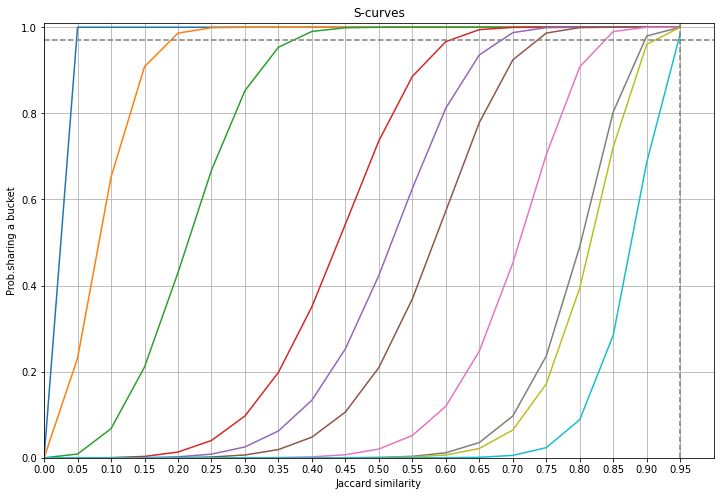

In [ ]:
r_all = [1,2,3,5,6,7,10,14,15,21,30,35,42,70,105,210] # all values such that r*b = 210
b_all = [210,105,70,42,35,30,21,15,14,10,7,6,5,3,2,1]

x = np.arange(0,1,0.05)

def s_curve(r, b, j = 0.95): # fixed Jaccard at level 0.95
    return 1 - ( ( 1 - (j**r) )**b )

s_output = [s_curve(x, y, j = 0.95) for (x, y) in zip(r_all, b_all)] 

s_value = [s for s in s_output if s > 0.97] # column

n = len(s_value)

r = r_all[:n]
b = b_all[:n] # this are the values that satisfy p > 0.97

y = [ 1 - ( ( 1 - (x**i) )**j ) for (i, j) in zip(r, b) ] 

fig, ax = plt.subplots(figsize=(12, 8))

for j in y:
    ax.plot(x,j)

plt.xlim([0, 1])
plt.ylim([0, 1.01])
ax.set_title('S-curves')
plt.xlabel('Jaccard similarity')
plt.ylabel('Prob.sharing a bucket')
plt.axhline(y = 0.97, xmin = 0, xmax = 1,color = "grey", linestyle = "dashed")
plt.axvline(x = 0.95, ymin = 0, ymax = 1,color = "grey", linestyle = "dashed")
plt.xticks(np.arange(0, 1, 0.05)) 
plt.grid()
plt.show()

We selected the green curve because it was the one with the smallest number of FN and even if it has a big number of false positives we are ok with it because it's running time is still under the maximum of 10 minutes.

In [ ]:
r = 3
b = 70

jaccard_threshold = 0.95

input_file_name = '/content/MinWiseHashing_sketch.tsv' 

output_file_name = 'NearDuplicates__set_a_id__set_b_id__approximate_jaccard.tsv' # near duplicates

start = time.time()
mine_couples_of_Near_Duplicates(input_file_name, r, b, jaccard_threshold)
end = time.time()

print("The time of execution of above program is :", (end-start)/60) # has to be under the 10 minutes constraint

The time of execution of above program is : 3.2639688650767007


In [ ]:
print('number of near-duplicates candidates found: ', len(pd.read_csv(output_file_name, sep='\t')))

number of near-duplicates candidates found:  34091
